# Final Detection

##  Ensure the sample counts of two datasets are consistent.

In [22]:
import pandas as pd

# 加载并对齐融合特征和情感特征
def load_and_align_features(fused_path, emotional_path):
    # 加载融合特征
    fused_features_df = pd.read_csv(fused_path, header=None)
    
    # 获取总列数
    num_cols = fused_features_df.shape[1]
    
    # 设置列名，倒数第二列是image_id，最后一列是label
    col_names = [f'feature_{i}' for i in range(num_cols - 2)] + ['image_id', 'label']
    fused_features_df.columns = col_names
    
    # 设置索引列为 image_id
    fused_features_df.set_index('image_id', inplace=True)
    
    # 加载情感特征
    emotional_features_df = pd.read_csv(emotional_path, index_col=0)
    
    # 确保索引类型一致
    fused_features_df.index = fused_features_df.index.astype(str)
    emotional_features_df.index = emotional_features_df.index.astype(str)
    
    # 删除重复值
    fused_features_df = fused_features_df[~fused_features_df.index.duplicated(keep='first')]
    emotional_features_df = emotional_features_df[~emotional_features_df.index.duplicated(keep='first')]
    
    # 找到共同的 image_id 并进行采样
    common_image_ids = fused_features_df.index.intersection(emotional_features_df.index)
    
    # 过滤数据以保留共同的 image_id
    fused_features_df = fused_features_df.loc[common_image_ids]
    emotional_features_df = emotional_features_df.loc[common_image_ids]
    
    return fused_features_df, emotional_features_df

# 通过 image_id 合并情感特征和标签
def merge_emotional_features_with_labels(emotional_features_df, fused_features_df):
    # 从 fused_features_df 中提取 label 列
    labels = fused_features_df['label']
    
    # 将 label 列合并到 emotional_features_df 中
    emotional_features_df = emotional_features_df.join(labels, how='inner')
    
    return emotional_features_df

# 文件路径
fused_features_path = 'fused_combined.csv'
emotional_features_path = 'SA_02.csv'

# 执行第一步
fused_features_df, emotional_features_df = load_and_align_features(fused_features_path, emotional_features_path)

# 打印前几行检查
print("Aligned Fused features:")
print(fused_features_df.head())

print("\nAligned Emotional features:")
print(emotional_features_df.head())

# 通过 image_id 合并情感特征和标签
emotional_features_with_labels_df = merge_emotional_features_with_labels(emotional_features_df, fused_features_df)

# 定义fused_merged_df和emotional_merged_df
fused_merged_df = fused_features_df
emotional_merged_df = emotional_features_with_labels_df

# 输出一个包含label的emotional features csv文件
# file_path = 'emotional_merged_df.csv'
#emotional_merged_df.to_csv(file_path, index=True)

# 打印前几行检查
print("Fused features with labels:")
print(fused_merged_df.head())

print("\nEmotional features with labels:")
print(emotional_merged_df.head())

# 检查样本数量是否一致
fused_sample_count = fused_merged_df.shape[0]
emotional_sample_count = emotional_merged_df.shape[0]

print(f'Fused features sample count: {fused_sample_count}')
print(f'Emotional features with labels sample count: {emotional_sample_count}')

if fused_sample_count != emotional_sample_count:
    print("Warning: The sample counts for fused features and emotional features with labels are not consistent.")
else:
    print("The sample counts for fused features and emotional features with labels are consistent.")

Aligned Fused features:
          feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
image_id                                                                     
awxhir     0.132731  -0.046325   0.048000  -0.054121  -0.265670   0.286993   
4xypkv     0.166932  -0.040577   0.022252  -0.036686  -0.257072   0.275591   
2cfi7g     0.141127  -0.032970   0.055993  -0.034640  -0.267474   0.290403   
212vud     0.172750  -0.065717  -0.025985  -0.075753  -0.179092   0.282487   
15ilmc     0.163937  -0.015764   0.043609  -0.071291  -0.271180   0.274031   

          feature_6  feature_7  feature_8  feature_9  ...  feature_1527  \
image_id                                              ...                 
awxhir    -0.201550   0.152168  -0.219680  -0.104517  ...     -0.233606   
4xypkv    -0.190400   0.157786  -0.211556  -0.094982  ...     -0.213467   
2cfi7g    -0.170492   0.175335  -0.225272  -0.110479  ...     -0.255146   
212vud    -0.175625   0.167229  -0.230976  -0.117548  

# Split train & test dataset 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 假设fused_merged_df和emotional_merged_df已经准备好

# 划分数据集为特征和标签
X_fused = fused_merged_df.reset_index().drop(['label'], axis=1)
y_fused = fused_merged_df['label']

X_emotional = emotional_merged_df.reset_index().drop(['label'], axis=1)
y_emotional = emotional_merged_df['label']

# 划分训练集和测试集
X_fused_train, X_fused_test, y_fused_train, y_fused_test = train_test_split(X_fused, y_fused, test_size=0.2, random_state=42)
X_emotional_train, X_emotional_test, y_emotional_train, y_emotional_test = train_test_split(X_emotional, y_emotional, test_size=0.2, random_state=42)

# 存储image_id以便之后合并
image_id_train_f = X_fused_train['image_id']
image_id_test_f = X_fused_test['image_id']

image_id_train_e = X_emotional_train['image_id']
image_id_test_e = X_emotional_test['image_id']

# 删除image_id列
X_fused_train = X_fused_train.drop(['image_id'], axis=1)
X_fused_test = X_fused_test.drop(['image_id'], axis=1)
X_emotional_train = X_emotional_train.drop(['image_id'], axis=1)
X_emotional_test = X_emotional_test.drop(['image_id'], axis=1)

# 标准化特征数据
scaler_fused = StandardScaler()
X_fused_train = scaler_fused.fit_transform(X_fused_train)
X_fused_test = scaler_fused.transform(X_fused_test)

scaler_emotional = StandardScaler()
X_emotional_train = scaler_emotional.fit_transform(X_emotional_train)
X_emotional_test = scaler_emotional.transform(X_emotional_test)

# 打印检查
print("Fused train set shape:", X_fused_train.shape)
print("Fused test set shape:", X_fused_test.shape)
print("Emotional train set shape:", X_emotional_train.shape)
print("Emotional test set shape:", X_emotional_test.shape)


Fused train set shape: (62996, 1536)
Fused test set shape: (15749, 1536)
Emotional train set shape: (62996, 4)
Emotional test set shape: (15749, 4)


# Fused Tensor

## PCA

New training dimensions: 189
New testing dimensions: 189
Total explained variance: 0.9500169963164575


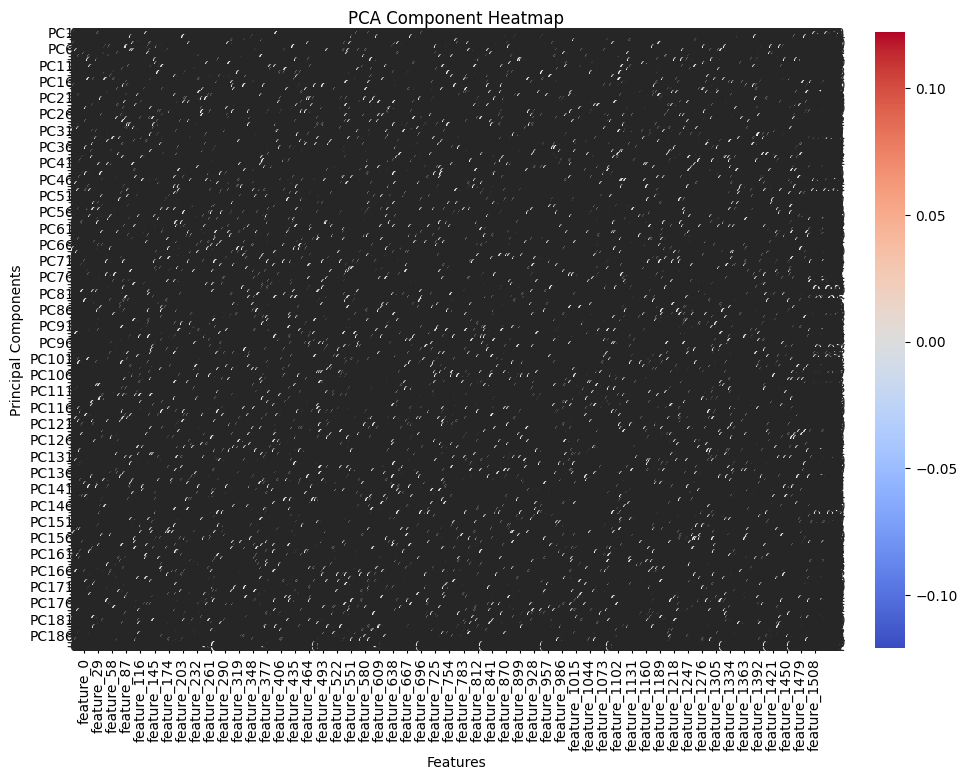

In [24]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 应用 PCA 降维，保持 95% 的方差
pca = PCA(n_components=0.95)
X_fused_train_pca = pca.fit_transform(X_fused_train)  # pca后的训练集
X_fused_test_pca = pca.transform(X_fused_test)  # pca后的测试集

# 检查新的维度和解释的方差比
print("New training dimensions:", X_fused_train_pca.shape[1])
print("New testing dimensions:", X_fused_test_pca.shape[1])
print("Total explained variance:", np.sum(pca.explained_variance_ratio_))

# 绘制热力图
# def plot_pca_heatmap(pca, features):
    # components = pca.components_
    # num_components = components.shape[0]
    
    # 创建一个DataFrame存储主成分和特征的关系
    # component_df = pd.DataFrame(components, columns=features, index=[f'PC{i+1}' for i in range(num_components)])
    
    # plt.figure(figsize=(12, 8))
    # sns.heatmap(component_df, cmap='coolwarm', annot=True, fmt=".2f")
    # plt.title('PCA Component Heatmap')
    # plt.xlabel('Features')
    # plt.ylabel('Principal Components')
    # plt.show()

# 获取原始特征名称
original_feature_names = fused_merged_df.columns[:-1]  # 去掉 'label' 列

# 绘制热力图
plot_pca_heatmap(pca, original_feature_names)


In [25]:
import pandas as pd

# 检查训练和测试标签中的 NaN 值
print("NaN values in y_fused_train:", y_fused_train.isna().sum())
print("NaN values in y_fused_test:", y_fused_test.isna().sum())



NaN values in y_fused_train: 0
NaN values in y_fused_test: 0


In [26]:
# 删除包含 NaN 值的样本
X_fused_train = X_fused_train[y_fused_train.notna()]
y_fused_train = y_fused_train.dropna()

X_fused_test = X_fused_test[y_fused_test.notna()]
y_fused_test = y_fused_test.dropna()


## MLP - 4 hidden layer

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# 根据最佳参数设置MLP分类器
mlp_fused = MLPClassifier(
    hidden_layer_sizes=(200,100,50,25,),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.01,
    max_iter=1100,
    random_state=42,
    batch_size= 64
)

# 创建Pipeline，包含标准化和PCA
pipeline_fused = make_pipeline(StandardScaler(), pca, mlp_fused)

# 训练模型
pipeline_fused.fit(X_fused_train, y_fused_train)

# 预测训练集和测试集
mlp_train_preds = pipeline_fused.predict(X_fused_train)
mlp_test_preds = pipeline_fused.predict(X_fused_test)

# 计算并打印训练集和测试集的准确率
mlp_train_accuracy = accuracy_score(y_fused_train, mlp_train_preds)
mlp_test_accuracy = accuracy_score(y_fused_test, mlp_test_preds)

print(f'Training accuracy: {mlp_train_accuracy}')
print(f'Testing accuracy: {mlp_test_accuracy}')

# 打印分类报告
print("\nClassification Report for Training Set:")
print(classification_report(y_fused_train, mlp_train_preds))

print("\nClassification Report for Testing Set:")
print(classification_report(y_fused_test, mlp_test_preds))

# 计算训练集和测试集的预测概率
fused_probs_train = pipeline_fused.predict_proba(X_fused_train)
fused_probs_test = pipeline_fused.predict_proba(X_fused_test)

# check 
print(f'fused_probs_train: {fused_probs_train[:5]}')
print(f'fused_probs_test: {fused_probs_test[:5]}')

# Emtional Tensor 

## Random Forest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# 创建随机森林分类器，使用已知的最佳参数
rf_emotional = RandomForestClassifier(
               max_depth=10, 
               min_samples_split=2, 
               n_estimators=200, 
               random_state=42)

# 创建Pipeline，包含标准化
pipeline_emotional = make_pipeline(StandardScaler(),rf_emotional)

# 使用训练数据拟合模型
pipeline_emotional.fit(X_emotional_train, y_emotional_train)

# 预测训练集和测试集
rf_train_preds = pipeline_emotional.predict(X_emotional_train)
rf_test_preds = pipeline_emotional.predict(X_emotional_test)

# 计算并打印训练集和测试集的准确率
rf_train_accuracy = accuracy_score(y_emotional_train, rf_train_preds)
rf_test_accuracy = accuracy_score(y_emotional_test, rf_test_preds)

print(f'Training accuracy: {rf_train_accuracy}')
print(f'Testing accuracy: {rf_test_accuracy}')

# 打印分类报告
print("\nClassification Report for Training Set:")
print(classification_report(y_emotional_train, rf_train_preds))

print("\nClassification Report for Testing Set:")
print(classification_report(y_emotional_test, rf_test_preds))

emotional_probs_train = pipeline_emotional.predict_proba(X_emotional_train)
emotional_probs_test = pipeline_emotional.predict_proba(X_emotional_test)

print(f'emotional_probs_train: {emotional_probs_train[:5]}')
print(f'emotional_probs_test: {emotional_probs_test[:5]}')

# Meta Model

## Data Merged

In [ ]:
import pandas as pd

# 确保 image_id 列都是字符串类型
image_id_train_f = [str(image_id) for image_id in image_id_train_f]
image_id_train_e = [str(image_id) for image_id in image_id_train_e]
image_id_test_f = [str(image_id) for image_id in image_id_test_f]
image_id_test_e = [str(image_id) for image_id in image_id_test_e]

# 预测所有类别的概率
fused_probs_train = pipeline_fused.predict_proba(X_fused_train)
fused_probs_test = pipeline_fused.predict_proba(X_fused_test)
emotional_probs_train = rf_emotional.predict_proba(X_emotional_train)
emotional_probs_test = rf_emotional.predict_proba(X_emotional_test)

# 获取类别标签
class_labels_fused = pipeline_fused.classes_
class_labels_emotional = rf_emotional.classes_

# 将概率转换为数据框，并添加列名
df_fused_probs_train = pd.DataFrame(fused_probs_train, columns=[f'fused_prob_{cls}' for cls in class_labels_fused])
df_fused_probs_test = pd.DataFrame(fused_probs_test, columns=[f'fused_prob_{cls}' for cls in class_labels_fused])
df_emotional_probs_train = pd.DataFrame(emotional_probs_train, columns=[f'emotional_prob_{cls}' for cls in class_labels_emotional])
df_emotional_probs_test = pd.DataFrame(emotional_probs_test, columns=[f'emotional_prob_{cls}' for cls in class_labels_emotional])

# 打印前几行检查
# print(f'df_fused_probs_train:')
# print(df_fused_probs_train.head())

# print(f'df_fused_probs_test:')
# print(df_fused_probs_test.head())

# print(f'df_emotional_probs_train:')
# print(df_emotional_probs_train.head())

# print(f'df_emotional_probs_test:')
# print(df_emotional_probs_test.head())


# 添加 image_id 列
df_fused_probs_train['image_id'] = image_id_train_f
df_fused_probs_test['image_id'] = image_id_test_f
df_emotional_probs_train['image_id'] = image_id_train_e
df_emotional_probs_test['image_id'] = image_id_test_e

# 创建包含 image_id 和标签的数据框
df_label_train = pd.DataFrame({
    'image_id': image_id_train_f,  # 假设训练集中的 image_id 与 fused_train 的相同
    'label': y_fused_train
})

df_label_test = pd.DataFrame({
    'image_id': image_id_test_f,  # 假设测试集中的 image_id 与 fused_test 的相同
    'label': y_fused_test
})

# 在合并之前重置索引
df_fused_probs_train = df_fused_probs_train.reset_index(drop=True)
df_emotional_probs_train = df_emotional_probs_train.reset_index(drop=True)
df_fused_probs_test = df_fused_probs_test.reset_index(drop=True)
df_emotional_probs_test = df_emotional_probs_test.reset_index(drop=True)
df_label_train = df_label_train.reset_index(drop=True)
df_label_test = df_label_test.reset_index(drop=True)

# 通过 image_id 对齐训练集数据
meta_train_df = pd.merge(df_fused_probs_train, df_emotional_probs_train, on='image_id')
meta_train_df = pd.merge(meta_train_df, df_label_train, on='image_id')

# 通过 image_id 对齐测试集数据
meta_test_df = pd.merge(df_fused_probs_test, df_emotional_probs_test, on='image_id')
meta_test_df = pd.merge(meta_test_df, df_label_test, on='image_id')

# 检查合并后的数据框
print(meta_train_df.head())
print(meta_test_df.head())


## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42, solver='lbfgs')

# 训练 MLP 模型
X_train = meta_train_df[['fused_prob_1', 'emotional_prob_1']]
y_train = meta_train_df['label']
mlp.fit(X_train, y_train)

# 预测所有样本的标签
X_test = meta_test_df[['fused_prob_1', 'emotional_prob_1']]
y_test = meta_test_df['label']
mlp_predictions = mlp.predict(X_test)

# 检查预测结果是否包含 NaN
# if any(pd.isna(mlp_predictions)):
    # print("MLP 预测结果中包含 NaN 值")

# 添加 'mlp_pred' 列    
meta_test_df['mlp_pred'] = mlp_predictions

# 计算并输出评估指标
accuracy = accuracy_score(y_test, mlp_predictions)
precision = precision_score(y_test, mlp_predictions, average='weighted')
recall = recall_score(y_test, mlp_predictions, average='weighted')
f1 = f1_score(y_test, mlp_predictions, average='weighted')
classification_rep = classification_report(y_test, mlp_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:")
print(classification_rep)

# 检查预测结果是否包含 NaN 值并打印前几行数据
print(meta_test_df['mlp_pred'].isnull().sum())
print(meta_test_df.head())


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression


# 使用逻辑回归进行训练
log_reg = LogisticRegression(max_iter=100, random_state=42)

# 训练逻辑回归模型
X_train = meta_train_df[['fused_prob_1', 'emotional_prob_1']]
y_train = meta_train_df['label']
log_reg.fit(X_train, y_train)

# 预测所有样本的标签
X_test = meta_test_df[['fused_prob_1', 'emotional_prob_1']]
y_test = meta_test_df['label']
log_reg_predictions = log_reg.predict(X_test)

# 检查预测结果是否包含 NaN
# if any(pd.isna(log_reg_predictions)):
    # print("逻辑回归预测结果中包含 NaN 值")

# 添加 'log_reg_pred' 列    
meta_test_df['log_reg_pred'] = log_reg_predictions

# 计算并输出评估指标
accuracy = accuracy_score(y_test, log_reg_predictions)
precision = precision_score(y_test, log_reg_predictions, average='weighted')
recall = recall_score(y_test, log_reg_predictions, average='weighted')
f1 = f1_score(y_test, log_reg_predictions, average='weighted')
classification_rep = classification_report(y_test, log_reg_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:")
print(classification_rep)

# 检查预测结果是否包含 NaN 值并打印前几行数据
# print(meta_test_df['log_reg_pred'].isnull().sum())
# print(meta_test_df.head())
